In [57]:
# code author: Preethi Ravula
# University of Maryland, College Park
# Date: April 2020
# Detecting yellow markers in images from the viewpoint of a camera‐carrying model car driving on a track

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2, os
import xlsxwriter
from skimage import color, measure, filters, exposure
from skimage.feature import canny, corner_harris, corner_peaks, corner_subpix
from skimage.util import img_as_ubyte
from skimage.restoration import denoise_bilateral
from skimage.restoration import inpaint
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [58]:
def canny_edge(image):
    # Apply bilateral filter denoising
    denoised_image = denoise_bilateral(image, 
                                   multichannel=True)
    im_gray = color.rgb2gray(denoised_image)
# apply Gaussian blur, creating a new image
    blurred = filters.gaussian(im_gray)
# perform adaptive thresholding
#    plt.imshow(im_gray1)
#    t = filters.threshold_otsu(im_gray1)
#    print(t)
#    im_gray = im_gray1 > 0.5
    
# Compute the Canny filter for two values of sigma
    edges1 = canny(blurred, sigma=1.2)
   # edges1 = canny(im_gray, sigma=1.5)
  #  edges2 = canny(im_gray, sigma=0.5)
    return edges1

In [59]:
def region_for_masking(img, vertices):

    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2] 
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
  
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [60]:
def masked_image(image):
    canny_img = canny_edge(image)
    point1 = [30, 120]
    point2 = [100, 90]
    point3 = [150, 80]
   # point4 = [250, 90]
    point5 = [300, 120]
    point6 = [300, 240]
    point7 = [0, 240]
    v = [np.array([point1, point2, point3, point5, point6, point7], dtype=np.int32)]
    cv_image = img_as_ubyte(canny_img)
    mask = region_for_masking(cv_image, v)
 #   plt.imshow(mask)  
    return mask

In [61]:
def edged_image(defect_image):
    mask = np.zeros(defect_image.shape[:-1])
    mask[228:241, 15:70] = 1
    mask[228:241, 250:310] = 1
    restored_image = inpaint.inpaint_biharmonic(defect_image, mask, multichannel=True)
    edged = masked_image(restored_image)
    borderLen = 2                         #The width to zero out the borders, counted in pixels
    lenx, leny = edged.shape
  
    edged[0:borderLen,0:leny] = 0
    edged[lenx-borderLen:lenx,0:leny] = 0
    edged[0:lenx,0:borderLen] = 0
    edged[0:lenx,leny-borderLen:leny] = 0
    return edged


In [62]:
images = []
folder = '/Users/Preethi/Desktop/images'
for filename in os.listdir(folder):
    try:
        img = mpimg.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    except:
        print('Error in loading' + filename)
img = np.asarray(images)

In [63]:
img.shape[:-1]

(11, 240, 320)

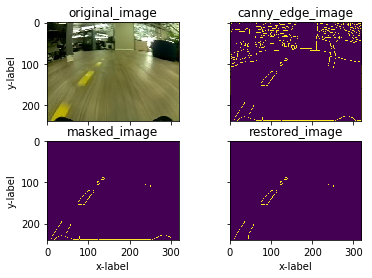

In [66]:
test_image = img[9]
restored_img = edged_image(test_image)
canny_img = canny_edge(test_image)
masked_img = masked_image(test_image)
#warp_image = perspective_warp3(restored_img)
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(test_image)
axs[0, 0].set_title('original_image')
axs[0, 1].imshow(canny_img)
axs[0, 1].set_title('canny_edge_image')
axs[1, 0].imshow(masked_img)
axs[1, 0].set_title('masked_image')
axs[1, 1].imshow(restored_img)
axs[1, 1].set_title('restored_image')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

for ax in axs.flat:
    ax.label_outer()
plt.savefig("restored_image.jpg") 

In [67]:
img.shape
img_total = img.shape[0]
img_new = np.zeros(img.shape[:-1])
d = 0

for i in range(img_total):
    defect_image = img[i]
    img_new[i] = edged_image(defect_image)
    file = "img_res%d.jpg"%d
    cv2.imwrite(file, img_new[i])
    d+=1
    

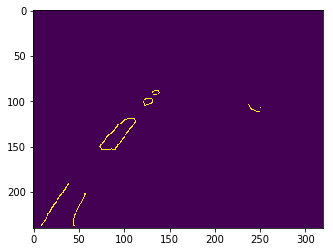

In [68]:
plt.imshow(img_new[9])
img_new[3].shape
plt.savefig("restored_image.jpg") 

In [44]:
outliers=[]
def detect_outliers(data_1):
    
    threshold=2
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

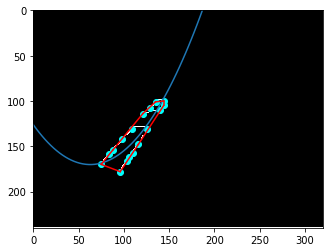

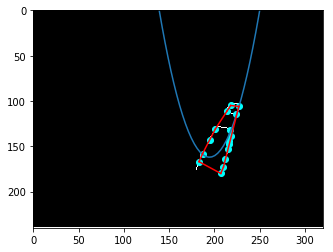

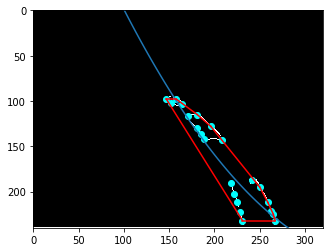

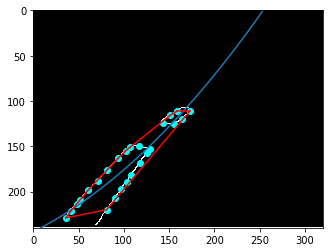

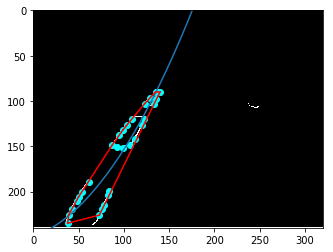

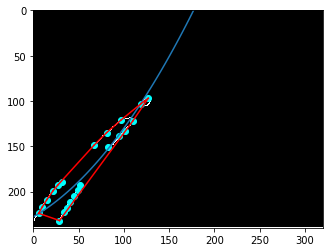

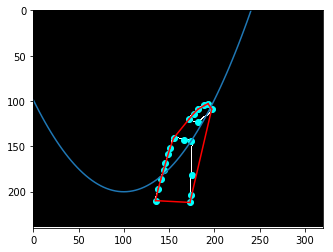

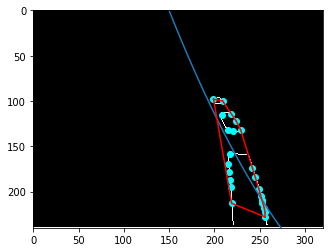

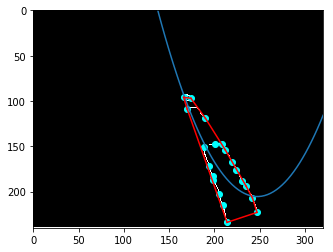

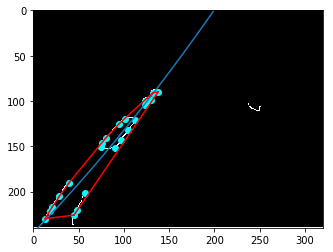

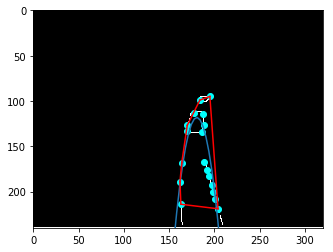

In [45]:
# for annotating the images and extracting yellow markers, 
# get the points on boundary of the markers for training lables

k = 0
pts_x = []
pts_y = []
final_ver = []
hull_x = []
hull_y = []

no_points = np.zeros(img_total)
for i in range(img_total):
    corner_image = img_new[i]
    measure_image = corner_harris(corner_image, 2, 5, 0.7)

# Find the peaks of the corners using the Harris detector
    coords = corner_peaks(measure_image, min_distance=3)
    outlier_datapoints = detect_outliers(coords[:,1])    
    coords_new = coords[~np.in1d(np.array(coords[:,1]), outlier_datapoints)]
    x = np.array(coords_new[:,1])
    y = np.array(coords_new[:,0])
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    xp = np.linspace(0, 320, 100)

    no_points[i] = len(coords[:,1])
    pts_x.append( list(coords_new[:,1]) )
    pts_y.append( list(coords_new[:,0]) )

    hull = ConvexHull(coords_new)
#plot figures
    fig, ax = plt.subplots()
    ax.imshow(corner_image, cmap=plt.cm.gray)
    ax.plot(x, y, color='cyan', marker='o',
             linestyle='None', markersize=6)
    ax.plot(xp, p(xp), '-')
 #   ax.plot(coords_new[hull.vertices,1], coords_new[hull.vertices,0], 'r--', lw=2)
 #   ax.plot(coords_new[hull.vertices[1],1], coords_new[hull.vertices[1],0], 'ro')
    for simplex in hull.simplices:
        ax.plot(coords_new[simplex, 1], coords_new[simplex, 0], 'k-', color='red')
#ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
    final_ver = coords_new[hull.simplices[:,1]]
    hull_x.append(list(final_ver[:,1]))
    hull_y.append(list(final_ver[:,0]))
    
    ax.axis((0, 320, 240, 0))
    plt.savefig("img_points%d.jpg"%k)

  #  hull_pts.append()
    k+=1
         

In [ ]:
workbook = xlsxwriter.Workbook('marker_points.xlsx')
worksheet1 = workbook.add_worksheet()
worksheet2 = workbook.add_worksheet()
worksheet3 = workbook.add_worksheet()
worksheet4 = workbook.add_worksheet()

row = 0

for col, data in enumerate(pts_x):
    worksheet1.write_column(row, col, data)
row = 0
for col, data in enumerate(pts_y):
    worksheet2.write_column(row, col, data)
for col, data in enumerate(hull_x):
    worksheet3.write_column(row, col, data)
row = 0
for col, data in enumerate(hull_y):
    worksheet4.write_column(row, col, data)
 

workbook.close()

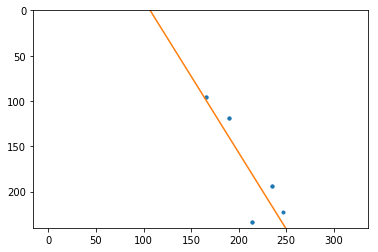

In [54]:
x = np.array(hull_x[8])
y = np.array(hull_y[8])
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
xp = np.linspace(0, 320, 100)
_ = plt.plot(x, y, '.', xp, p(xp), '-')
plt.ylim(240,0)
plt.show()

In [56]:
#def perspective_warp3(img, dst_size=(320, 240),
#                 src=np.float32([(160, 110), (172, 111), (142, 122), (154, 123)]),
#                 dst=np.float32([(60, 110), (72.06, 110), (60, 131.6), (72.06, 141.6)])):
#[(110 160), (111 172), (116 151), (122 142), (123 159)]¶
#img_size = np.float32([(img.shape[1],img.shape[0])])
#src = src* img_size
#dst = dst * np.float32(dst_size)
# calculate the perspective transform matrix
#M = cv2.getPerspectiveTransform(src, dst)
#warped = cv2.warpPerspective(img, M, dst_size)
#return warped

SyntaxError: 'return' outside function (<ipython-input-56-6de390a91741>, line 12)